In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Fiat.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_500 Ailesi,Seri_Albea,Seri_Brava,...,Model_Sole 1.4 Fire Dynamic,Model_Sole 1.4 Fire Dynamic Plus,Model_Sole 1.4 Fire Premio,Model_Sole 1.4 Fire Premio Plus,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,352750,2010,77,1368,260000,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,488000,2017,120,1598,211000,5.0,3.0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,630000,2021,95,1368,40550,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,750000,2023,95,1368,6100,NaN,NaN,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,425000,2018,95,1248,187000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_16028\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,34542.945065,1.076541e+09,32810.677367,23518.423748


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:10:37,488] A new study created in memory with name: no-name-97f937d4-0c28-42c7-8e66-6b1d582b2bb9
[I 2023-10-08 14:10:37,849] Trial 0 finished with value: 158618.80848545991 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.09422703306262543, 'max_depth': 7, 'min_child_weight': 195}. Best is trial 0 with value: 158618.80848545991.
[I 2023-10-08 14:10:37,849] Trial 5 finished with value: 396305.6746923825 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.0008720743386681936, 'max_depth': 10, 'min_child_weight': 256}. Best is trial 0 with value: 158618.80848545991.
[I 2023-10-08 14:10:37,881] Trial 1 finished with value: 399062.4490387993 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.00010931963388104157, 'max_depth': 3, 'min_child_weight': 26}. Best is trial 0 with value: 158618.80848545991.
[I 2023-10-08 14:10:37,927] Trial 6 finished with value: 53395.54374336104 and parameters: 

[I 2023-10-08 14:10:39,899] Trial 30 finished with value: 140072.18007738722 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.1050935352990653, 'max_depth': 13, 'min_child_weight': 58}. Best is trial 19 with value: 34736.57236324166.
[I 2023-10-08 14:10:39,899] Trial 29 finished with value: 146082.07999509826 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.10104266838777683, 'max_depth': 13, 'min_child_weight': 62}. Best is trial 19 with value: 34736.57236324166.
[I 2023-10-08 14:10:40,079] Trial 32 finished with value: 140805.27689618728 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.10455568424845231, 'max_depth': 14, 'min_child_weight': 66}. Best is trial 19 with value: 34736.57236324166.
[I 2023-10-08 14:10:40,094] Trial 33 finished with value: 92245.21240388721 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.14871823976331874, 'max_depth': 14, 'min_child_weig

[I 2023-10-08 14:10:42,480] Trial 60 finished with value: 76106.00764070111 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.17303397278901533, 'max_depth': 14, 'min_child_weight': 43}. Best is trial 46 with value: 34556.212354272.
[I 2023-10-08 14:10:42,515] Trial 61 finished with value: 88694.95708062925 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.16018568912849906, 'max_depth': 14, 'min_child_weight': 39}. Best is trial 46 with value: 34556.212354272.
[I 2023-10-08 14:10:42,652] Trial 62 finished with value: 68941.08458718138 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.18429763325434695, 'max_depth': 14, 'min_child_weight': 38}. Best is trial 46 with value: 34556.212354272.
[I 2023-10-08 14:10:42,765] Trial 63 finished with value: 67400.42973351658 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.18348857562785537, 'max_depth': 14, 'min_child_weight': 34}

[I 2023-10-08 14:10:45,497] Trial 90 finished with value: 43325.366281803595 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.24793741970911545, 'max_depth': 9, 'min_child_weight': 3}. Best is trial 68 with value: 34194.514351853475.
[I 2023-10-08 14:10:45,531] Trial 92 finished with value: 41541.73083195755 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.2580206830458163, 'max_depth': 9, 'min_child_weight': 7}. Best is trial 68 with value: 34194.514351853475.
[I 2023-10-08 14:10:45,578] Trial 91 finished with value: 42733.58889489232 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.2503195390450166, 'max_depth': 10, 'min_child_weight': 8}. Best is trial 68 with value: 34194.514351853475.
[I 2023-10-08 14:10:45,711] Trial 94 finished with value: 110649.93806927919 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.1363537680267883, 'max_depth': 13, 'min_child_weight': 

[I 2023-10-08 14:10:48,358] Trial 120 finished with value: 60372.16880364241 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.19518352363149316, 'max_depth': 14, 'min_child_weight': 13}. Best is trial 116 with value: 33023.29190309698.
[I 2023-10-08 14:10:48,564] Trial 121 finished with value: 37633.90002066613 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.28455753608492684, 'max_depth': 14, 'min_child_weight': 13}. Best is trial 116 with value: 33023.29190309698.
[I 2023-10-08 14:10:48,693] Trial 122 finished with value: 61441.03756752476 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.20069472203116176, 'max_depth': 3, 'min_child_weight': 13}. Best is trial 116 with value: 33023.29190309698.
[I 2023-10-08 14:10:48,905] Trial 124 finished with value: 56732.843137046 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.20329005269745765, 'max_depth': 14, 'min_child_we

[I 2023-10-08 14:10:51,676] Trial 150 finished with value: 35052.44863496821 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.33030904534162076, 'max_depth': 15, 'min_child_weight': 19}. Best is trial 116 with value: 33023.29190309698.
[I 2023-10-08 14:10:51,691] Trial 152 finished with value: 34195.34490201652 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.33999268285418355, 'max_depth': 15, 'min_child_weight': 18}. Best is trial 116 with value: 33023.29190309698.
[I 2023-10-08 14:10:51,754] Trial 151 finished with value: 34532.68882773213 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.3335901270658512, 'max_depth': 15, 'min_child_weight': 19}. Best is trial 116 with value: 33023.29190309698.
[I 2023-10-08 14:10:51,832] Trial 153 finished with value: 34404.99545176321 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.3283448796201181, 'max_depth': 14, 'min_child_w

[I 2023-10-08 14:10:54,958] Trial 180 finished with value: 49383.20064524195 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.3921273440154606, 'max_depth': 15, 'min_child_weight': 228}. Best is trial 116 with value: 33023.29190309698.
[I 2023-10-08 14:10:54,998] Trial 179 finished with value: 34831.72380266226 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.4096882238454174, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 116 with value: 33023.29190309698.
[I 2023-10-08 14:10:55,262] Trial 182 finished with value: 36821.17148714124 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.40341100680909914, 'max_depth': 15, 'min_child_weight': 7}. Best is trial 116 with value: 33023.29190309698.
[I 2023-10-08 14:10:55,446] Trial 183 finished with value: 39200.60334725722 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.34629141385020096, 'max_depth': 15, 'min_child_we

[I 2023-10-08 14:10:58,459] Trial 210 finished with value: 33354.69727067485 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.35825262553859744, 'max_depth': 6, 'min_child_weight': 17}. Best is trial 201 with value: 32685.35291770232.
[I 2023-10-08 14:10:58,919] Trial 213 finished with value: 33823.67098961994 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.3617053536009825, 'max_depth': 7, 'min_child_weight': 9}. Best is trial 201 with value: 32685.35291770232.
[I 2023-10-08 14:10:58,919] Trial 212 finished with value: 33137.283618938774 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.36774242966632226, 'max_depth': 5, 'min_child_weight': 9}. Best is trial 201 with value: 32685.35291770232.
[I 2023-10-08 14:10:58,997] Trial 211 finished with value: 33218.45576467013 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.36545894925060995, 'max_depth': 7, 'min_child_weigh

[I 2023-10-08 14:11:02,144] Trial 239 finished with value: 34557.98889414408 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.43005103513858506, 'max_depth': 4, 'min_child_weight': 15}. Best is trial 201 with value: 32685.35291770232.
[I 2023-10-08 14:11:02,191] Trial 243 finished with value: 33432.67435319887 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4264829341177121, 'max_depth': 5, 'min_child_weight': 15}. Best is trial 201 with value: 32685.35291770232.
[I 2023-10-08 14:11:02,207] Trial 241 finished with value: 34562.401876403885 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4281898689333434, 'max_depth': 4, 'min_child_weight': 15}. Best is trial 201 with value: 32685.35291770232.
[I 2023-10-08 14:11:02,238] Trial 242 finished with value: 34743.806509248614 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4313010015636986, 'max_depth': 4, 'min_child_weig

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 32685.3529
Best params:
	colsample_bytree: 1.0
	subsample: 1.0
	learning_rate: 0.4323661297676851
	max_depth: 7
	min_child_weight: 19


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 37738.656648811484, 'MSE': 1136789911.3528774, 'RMSE': 33716.31521018982, 'MAE': 25327.296544428773}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9607531257442833

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.9552276858904764

In [16]:
marka_model = joblib.dump(final_model, "Fiat.pkl")

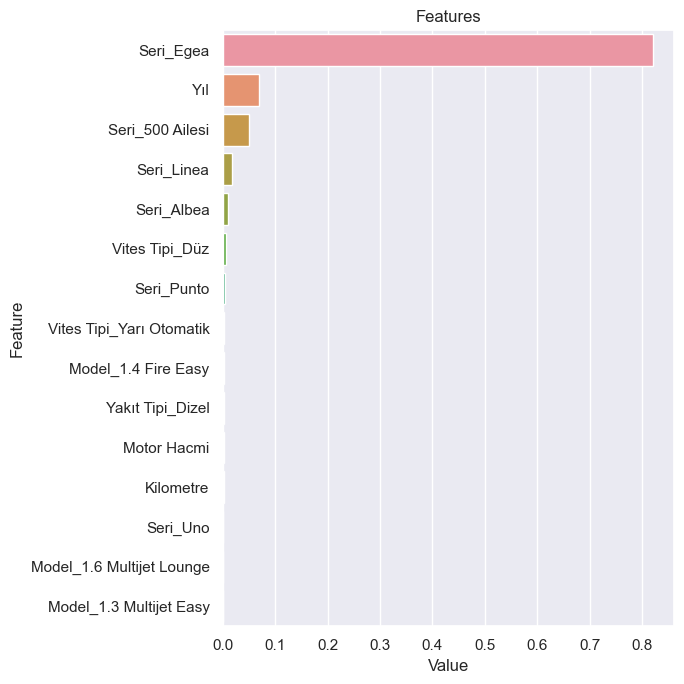

In [17]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)